<a href="https://colab.research.google.com/github/sarvasvaKhare/ActiveFlowControl/blob/main/ActiveFC_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-ofil5o9_/gym-walk_dcd9a994081a48f5b2f83640f4c54864
  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk /tmp/pip-install-ofil5o9_/gym-walk_dcd9a994081a48f5b2f83640f4c54864
  Resolved https://github.com/mimoralea/gym-walk to commit 5999016267d6de2f5a63307fb00dfd63de319ac1
  Preparing metadata (setup.py) ... done
  Created wheel for gym-walk: filename=gym_walk-0.0.2-py3-none-any.whl size=4072 sha256=7916971f68f6675805582859f4e8d3e12fe0bcb0c80084d9126d6f129c7a0d70
  Stored in directory: /tmp/pip-ephem-wheel-cache-hcgamf1g/wheels/a0/06/79/f12b4fd66f50f294342e5ea3d97dc3c01ee0511f659b28b6de
Successfully built gym-walk


In [ ]:
from os import makedirs
from os.path import join
from typing import Dict
import gym, gym_walk
import torch as pt
import numpy as np
import matplotlib.pyplot as plt

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
makedirs(output, exist_ok=True)

In [ ]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
P = env.env.P
list(P.items())[-2:]

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[(7,
  {0: [(0.5000000000000001, 6, 0.0, False),
    (0.3333333333333333, 7, 0.0, False),
    (0.16666666666666666, 8, 1.0, True)],
   1: [(0.5000000000000001, 8, 1.0, True),
    (0.3333333333333333, 7, 0.0, False),
    (0.16666666666666666, 6, 0.0, False)]}),
 (8,
  {0: [(0.5000000000000001, 8, 0.0, True),
    (0.3333333333333333, 8, 0.0, True),
    (0.16666666666666666, 8, 0.0, True)],
   1: [(0.5000000000000001, 8, 0.0, True),
    (0.3333333333333333, 8, 0.0, True),
    (0.16666666666666666, 8, 0.0, True)]})]

In [ ]:
def value_iteration(P: Dict[int, Dict[int, tuple]], gamma: float=0.99, theta: float=1e-10):
    V = pt.zeros(len(P))
    while True:
        Q = pt.zeros((len(P), len(P[0])))
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if pt.max(pt.abs(V - pt.max(Q, dim=1).values)) < theta:
            break
        V = pt.max(Q, dim=1).values
    pi = lambda s: {s:a for s, a in enumerate(pt.argmax(Q, dim=1))}[s]
    return Q, V, pi

In [ ]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P)
optimal_Q[1:-1]

tensor([[0.3119, 0.5637],
        [0.6703, 0.7630],
        [0.8032, 0.8449],
        [0.8638, 0.8892],
        [0.9014, 0.9220],
        [0.9322, 0.9515],
        [0.9613, 0.9806]])

In [ ]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [ ]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    Q = pt.zeros((nS, nA))
    select_action = lambda state, Q, epsilon: pt.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    alphas = decay_schedule(init_alpha, 
                           min_alpha, 
                           alpha_decay_ratio, 
                           n_episodes)
    epsilons = decay_schedule(init_epsilon, 
                              min_epsilon, 
                              epsilon_decay_ratio, 
                              n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [ ]:
optimal_Q

tensor([[0.0000, 0.0000],
        [0.3119, 0.5637],
        [0.6703, 0.7630],
        [0.8032, 0.8449],
        [0.8638, 0.8892],
        [0.9014, 0.9220],
        [0.9322, 0.9515],
        [0.9613, 0.9806],
        [0.0000, 0.0000]])

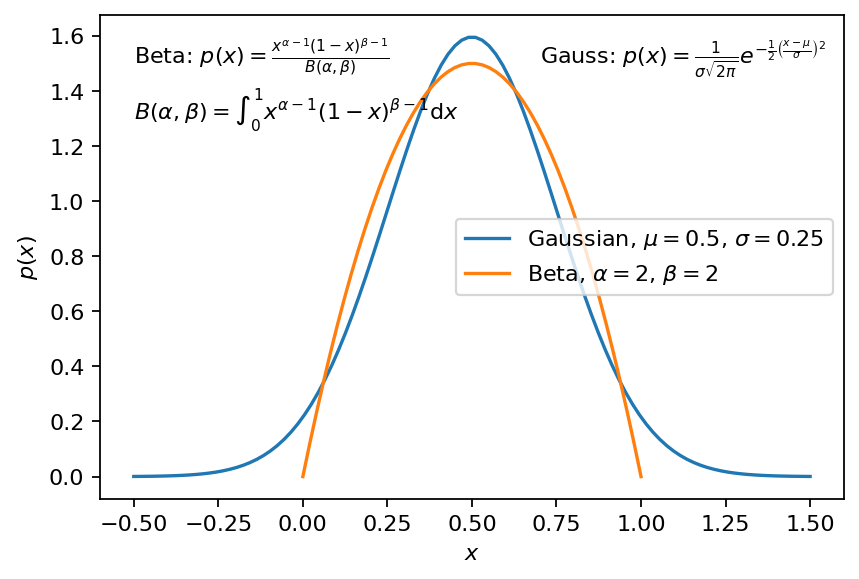

In [ ]:
x = pt.linspace(-0.5, 1.5, 100)
x01 = pt.linspace(0, 1, 50)
mu, std = 0.5, 0.5
gauss = pt.exp(-0.5*((x-mu)/std)**2) / (std * pt.sqrt(pt.tensor(2*np.pi)))
gauss = pt.distributions.Normal(0.5, 0.25)
gauss_pdf = gauss.log_prob(x).exp()
beta = pt.distributions.Beta(2, 2)
beta_pdf = beta.log_prob(x01).exp()

plt.plot(x, gauss_pdf, label=r"Gaussian, $\mu=0.5$, $\sigma = 0.25$")
plt.plot(x01, beta_pdf, label=r"Beta, $\alpha=2$, $\beta = 2$")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x)$")
plt.text(0.7, 1.5, r"Gauss: $p(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$")
plt.text(-0.5, 1.5, r"Beta: $p(x) = \frac{x^{\alpha - 1} (1-x)^{\beta - 1}}{B(\alpha, \beta)}$")
plt.text(-0.5, 1.3, r"$B(\alpha, \beta ) = \int_0^1 x^{\alpha - 1} (1-x)^{\beta - 1} \mathrm{d}x$")
plt.savefig(join(output, "gauss_vs_beta_dist.svg"), bbox_inches="tight")

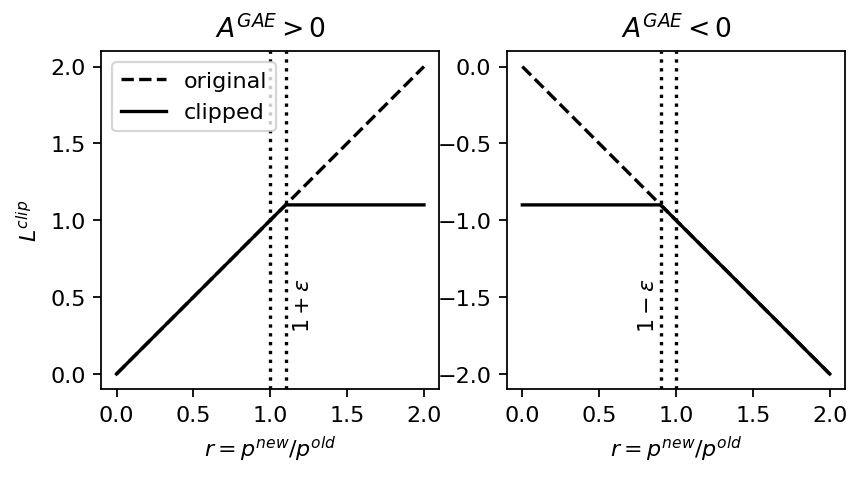

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

rp = pt.linspace(0, 2, 50)
rn = pt.linspace(-2, 0, 50)
eps = 0.1

ax1.plot(rp, rp, c="k", ls="--", label="original")
ax1.plot(rp, pt.min(rp, rp.clip(1-eps, 1+eps)), c="k", label="clipped")
ax1.axvline(1.0, c="k", ls=":")
ax1.axvline(1.0+eps, c="k", ls=":")
ax1.text(1.15, 0.3, r"$1+\epsilon$", rotation=90)
ax1.set_ylabel(r"$L^{clip}$")
ax1.set_title(r"$A^{GAE} > 0$")
ax1.legend()

ax2.plot(rp, -rp, c="k", ls="--")
ax2.plot(rp, pt.min(-rp, -rp.clip(1-eps, 1+eps)), c="k")
ax2.axvline(1.0, c="k", ls=":")
ax2.axvline(1.0-eps, c="k", ls=":")
ax2.text(0.75, -1.7, r"$1-\epsilon$", rotation=90)
ax2.set_title(r"$A^{GAE} < 0$")

for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel(r"$r = p^{new}/p^{old}$")
    

plt.savefig(join(output, "ppo_policy_loss_clipping.svg"), bbox_inches="tight")